In [1]:
import meshio
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import FaceToEdge
import matplotlib.pyplot as plt
%matplotlib notebook
from itertools import combinations
from einops import rearrange
import numpy as np

In [2]:
class TetraToEdge(object):
    r"""Converts mesh tetras :obj:`[4, num_tetras]` to edge indices
    :obj:`[2, num_edges]`.
    Args:
        remove_tetras (bool, optional): If set to :obj:`False`, the tetra tensor
            will not be removed.
    """

    def __init__(self, remove_tetras=True):
        self.remove_tetras = remove_tetras

    def __call__(self, data):
        if data.tetra is not None:
            tetra = data.tetra
            edge_index = torch.cat([tetra[:2], tetra[1:3, :], tetra[-2:], tetra[::2], tetra[::3], tetra[1::2]], dim=1)
            edge_index = to_undirected(edge_index, num_nodes=data.num_nodes)

            data.edge_index = edge_index
            if self.remove_tetras:
                data.tetra = None

        return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

class TetraToNeighbors(object):
    """Converts a graph of tetrahedrons to two matrixes: the faces of each tetrahedron (Tx4) and 
    the tetrahedrons that share a face (Fx2)"""
    def __init__(self):
        pass
    
    def __call__(self, data):
        """
        return:
        tetra_face: torch.Tensor(num_tetra, 4). Connects tetrahedrons (idx) to their faces (values)
        face_tetra: torch.Tensor(num_faces, 2). Connects faces (idx) to the tetrahedrons that share them (values).
            Each face must belong to at most 2 tetrahedrons. -1 where there is no tetrahedron i.e. at the edge.
        """
        assert data.tetra is not None, 'The graph must have tetrahedron data'
        N_tetra = data.tetra.shape[1]
        tetra_face = torch.tensor(list(range(N_tetra * 4)), dtype=torch.int64).reshape(N_tetra, 4)
        face_tetra = - torch.ones((4 * N_tetra, 2), dtype=torch.int64)
        
        i_face = 0
        combs = list(combinations(range(4), 3))
        for i_tetra in range(N_tetra):
            vtx_tetra = data.tetra[:, i_tetra]
            for i, j, k in combs:
                i_v = vtx_tetra[i]
                j_v = vtx_tetra[j]
                k_v = vtx_tetra[k]
                adj_tetra = torch.where((data.tetra == i_v).any(0) & (data.tetra == j_v).any(0) & 
                                        (data.tetra == k_v).any(0))[0]

                if len(adj_tetra) == 1:
                    face_tetra[i_face, 0] = adj_tetra
                else: # 2. Maximum is 2 and 0 is impossible.
                    face_tetra[i_face] = adj_tetra
                i_face += 1
        
        data.tetra_face = tetra_face
        data.face_tetra = face_tetra
        return data
    
    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
class TetraCoordinates(object):
    r"""
    Given a list of the xyz coordinates of the vertices of a tetrahedron, 
    return tetrahedron coordinate system
    """

    def __init__(self):
        pass

    def __call__(self, data):
        num_tetra = data.tetra.shape[1]
        # This can be done in one line, but...
        ori = data.pos[data.tetra[0]]
        v1 = data.pos[data.tetra[1]] - ori
        v2 = data.pos[data.tetra[2]] - ori
        v3 = data.pos[data.tetra[3]] - ori

        v1r = v1.T.reshape((3, 1, num_tetra))
        v2r = v2.T.reshape((3, 1, num_tetra))
        v3r = v3.T.reshape((3, 1, num_tetra))
        # mat defines an affine transform from the tetrahedron to the orthogonal system
        mat = torch.cat((v1r, v2r, v3r), dim=1)
        # The inverse matrix does the opposite (from orthogonal to tetrahedron)
        inv_mat = torch.linalg.inv(mat.T).T 
        
        data.ort_tetra = inv_mat
        data.origin = ori
        return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [3]:
def from_meshio(mesh, mesh_type='2D'):
    r"""Converts a :.msh file to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        mesh (meshio.read): A :obj:`meshio` mesh.
    """

    if meshio is None:
        raise ImportError('Package `meshio` could not be found.')

    pos = torch.from_numpy(mesh.points).to(torch.float)
    if mesh_type == '3D':
        tetra = torch.from_numpy(mesh.cells_dict['tetra']).to(torch.long).t().contiguous()
        #face = torch.from_numpy(mesh.cells_dict['triangle']).to(torch.long).t().contiguous()
        return Data(pos=pos, tetra=tetra)
    elif mesh_type == '2D':
        face = torch.from_numpy(mesh.cells_dict['triangle']).to(torch.long).t().contiguous()
        return Data(pos=pos, face=face)

In [4]:
mesh_type = '3D'
filename = '../meshes/sphere_coarse.msh'

mesh = meshio.read(filename)

data = from_meshio(mesh, mesh_type=mesh_type)

data = TetraToEdge(remove_tetras=False)(data)
data = TetraToNeighbors()(data)
data = TetraCoordinates()(data)

In [5]:
data

Data(edge_index=[2, 11746], origin=[4310, 3], ort_tetra=[3, 3, 4310], pos=[1001, 3], tetra=[4, 4310])

In [6]:
def get_neighbour_tetra(data, current_tetra, exit_face_local):
    exit_face = data.tetra_face[current_tetra, exit_face_local]  # Face number 2 in the local space of the tetrahedron
    return data.face_tetra[exit_face]

In [7]:
def find_tetrahedron_point(data, point):
    # Very much from https://stackoverflow.com/questions/25179693/how-to-check-whether-the-point-is-in-the-tetrahedron-or-not
    n_p = point.shape[0]
    orir = torch.repeat_interleave(data.origin.unsqueeze(-1), n_p, dim=2)
    newp = torch.einsum('imk, kmj -> kij', data.ort_tetra, point.T - orir)
    val = torch.all(newp >= 0, dim=1) & torch.all(newp <=1, dim=1) & (torch.sum(newp, dim=1) <= 1)
    id_tet, id_p = torch.nonzero(val, as_tuple=True)
    
    res = - torch.ones(n_p, dtype=id_tet.dtype) # Sentinel value
    res[id_p] = id_tet
    return res

In [8]:
def batch_dot(v1, v2):
    return torch.einsum('b d, b d -> b', v1, v2)

### Ahora empieza 

In [9]:
num_nodes = data.pos.shape[0]
num_tetra = data.tetra.shape[1]

In [10]:
coords_vertex_tetra = rearrange(data.pos[data.tetra], 'v t c -> t c v')

In [11]:
k = torch.cat((torch.ones((num_tetra, 1, 4)), coords_vertex_tetra), dim=1).inverse()

In [12]:
k.shape

torch.Size([4310, 4, 4])

In [13]:
n_index = - 0.5 * data.pos.norm(dim=1) + 1.5

In [14]:
n_index.shape

torch.Size([1001])

In [15]:
n_index[data.tetra[:,0]]

tensor([1.2327, 1.1041, 1.1248, 1.0852])

In [16]:
n_index[data.tetra].shape

torch.Size([4, 4310])

In [17]:
ab = torch.bmm(torch.transpose(k, 1, 2), n_index[data.tetra].T.unsqueeze(-1))
a = ab[:,0,0]
b = ab[:, 1:, 0]

In [18]:
n = b/b.norm()

In [19]:
ab.shape

torch.Size([4310, 4, 1])

In [20]:
b.shape, n.shape

(torch.Size([4310, 3]), torch.Size([4310, 3]))

In [21]:
data.n = n
data.k = k
data.a = a
data.b = b
data.n_index = n_index

Encontrar el tetraedro inicial

In [35]:
r0 = torch.tensor([[0.05, 0.1, 0.], [0.05, 0.10, 0.]])
m0 = torch.tensor([[1, 0, 0], [-1, 0, 0]], dtype=torch.float32)

In [32]:
tetra_idx = find_tetrahedron_point(data, rp)

In [33]:
tetra_idx

tensor([4278, 4278])

In [24]:
wrap_to_2pi = lambda x: x % (2 * np.pi) + (2 * np.pi) * (x == 0)

In [70]:
def evolve_in_tetra(data, tetra_idx, rp, m):
    bs = m.shape[0]
    k = data.k[tetra_idx]
    a = data.a[tetra_idx]
    b = data.b[tetra_idx]
    p = data.pos[data.tetra[:, tetra_idx]]
    n = data.n[tetra_idx]
    p = rearrange(p, 'p b c -> b p c')

    mn = torch.cross(m, n)
    q = mn / torch.sqrt(batch_dot(mn, mn).unsqueeze(1))
    nq = torch.cross(n, q)
    mn_dot = batch_dot(m, n).unsqueeze(1)
    rc = rp - (batch_dot(rp, n) + a/b.norm()).unsqueeze(1) * (n - (mn_dot * nq) / batch_dot(m, nq).unsqueeze(1))
    R = rc - rp

    phiR = torch.zeros((bs, 4))
    combs = list(combinations(range(4), 3))
    for it, (ii, ij, ik) in enumerate(combs):
        i = p[:, ii]
        j = p[:, ij]
        k = p[:, ik]

        M_L0 = (j[:, 1] - i[:, 1]) * (k[:, 2] - i[:, 2]) - (k[:, 1] - i[:, 1]) * (j[:, 2] - i[:, 2])
        M_L1 = (j[:, 2] - i[:, 2]) * (k[:, 0] - i[:, 0]) - (k[:, 2] - i[:, 2]) * (j[:, 0] - i[:, 0])
        M_L2 = (j[:, 0] - i[:, 0]) * (k[:, 1] - i[:, 1]) - (k[:, 0] - i[:, 0]) * (j[:, 1] - i[:, 1])
        M_L = torch.stack((M_L0, M_L1, M_L2), dim=1)
        Q_L = - batch_dot(i, M_L)

        c1 = - batch_dot(M_L, R)
        c2 = R.norm() * batch_dot(M_L, m)
        c3 = batch_dot(M_L, rc) + Q_L

        #if c1 == c3:
        #    phi1 = -2*torch.atan(c1/c2)
        #    phi2 = phi1
        #else:
        phi1 = 2 * torch.atan((c2 + torch.sqrt(c1.pow(2) + c2.pow(2) - c3.pow(2)))/(c1-c3))
        phi2 = 2 * torch.atan((c2 - torch.sqrt(c1.pow(2) + c2.pow(2) - c3.pow(2)))/(c1-c3))
        phi1 = wrap_to_2pi(phi1)
        phi2 = wrap_to_2pi(phi2)
        phi_cat = torch.stack([phi1, phi2], dim=-1)
        phiR[:, it] = phi_cat.min(dim=1).values

    phiR = torch.nan_to_num(phiR, nan=10)
    phiE, idx_face = phiR.min(dim=1, keepdim=True)
    phiE_eps = phiE + 5e-1  # This is to find the new tetrahedron

    # New direction and position
    re = rc - torch.cos(phiE) * R + R.norm()*torch.sin(phiE)*m
    re_eps = rc - torch.cos(phiE_eps) * R + R.norm()*torch.sin(phiE_eps)*m
    me = torch.cos(phiE)*m + torch.sin(phiE)/R.norm() * R

    # This is not the best way.
    next_tetra = find_tetrahedron_point(data, re_eps)
    return next_tetra, re, me

In [75]:
new_idx = tetra_idx.clone()
r = r0.clone()
m = m0.clone()
i = 0
r_hist = []
m_hist = []
idx_hist = []
while not (new_idx == -1).any() and i < 20:
    new_idx, r, m = evolve_in_tetra(data, new_idx, r, m)
    r_hist.append(r.numpy())
    m_hist.append(m.numpy())
    idx_hist.append(new_idx.numpy())
    i += 1

In [76]:
idx_hist

[array([ 147, 4277], dtype=int64),
 array([ 147, 4277], dtype=int64),
 array([4276, 4277], dtype=int64),
 array([ 147, 4278], dtype=int64),
 array([360, 904], dtype=int64),
 array([360, 173], dtype=int64),
 array([794, 173], dtype=int64),
 array([2456, 2637], dtype=int64),
 array([2456,  140], dtype=int64),
 array([2456,  320], dtype=int64),
 array([2456,  140], dtype=int64),
 array([2133,  140], dtype=int64),
 array([2047, 1891], dtype=int64),
 array([2788, 1797], dtype=int64),
 array([2788, 2112], dtype=int64),
 array([3525, 2079], dtype=int64),
 array([2797,   -1], dtype=int64)]

In [73]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

<IPython.core.display.Javascript object>


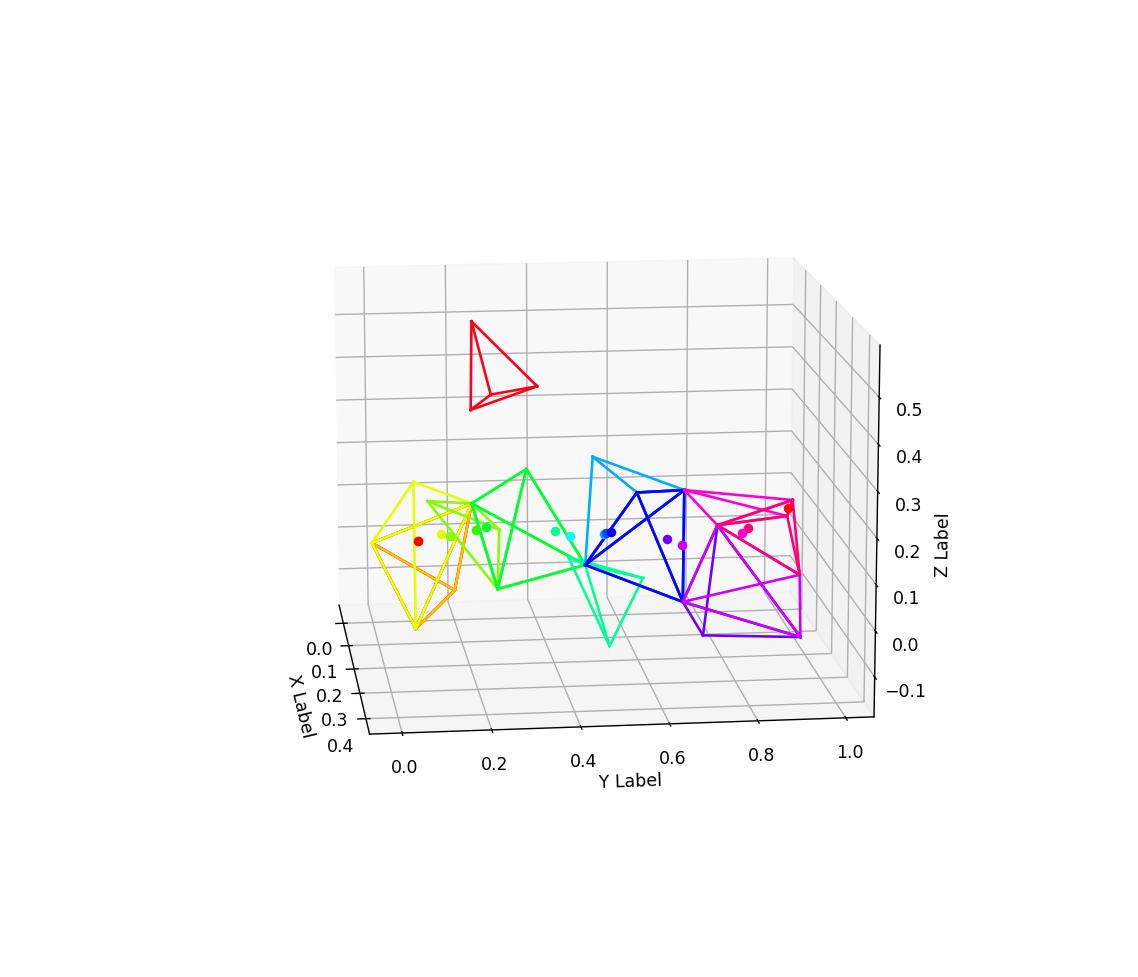

In [77]:
point_in_batch = 1
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
cmap = get_cmap(len(r_hist))

for i, (idx, r_plot) in enumerate(zip(idx_hist, r_hist)):
    p = data.pos[data.tetra[:, idx]]
    vertex = p[:,point_in_batch].numpy()
    lines = combinations(vertex, 2)
    for x in lines:
        line = np.transpose(np.array(x))
        ax.plot3D(line[0], line[1], line[2], c=cmap(i))
    ax.scatter(r_plot[point_in_batch,0], r_plot[point_in_batch,1], r_plot[point_in_batch,2], color=cmap(i))

<IPython.core.display.Javascript object>


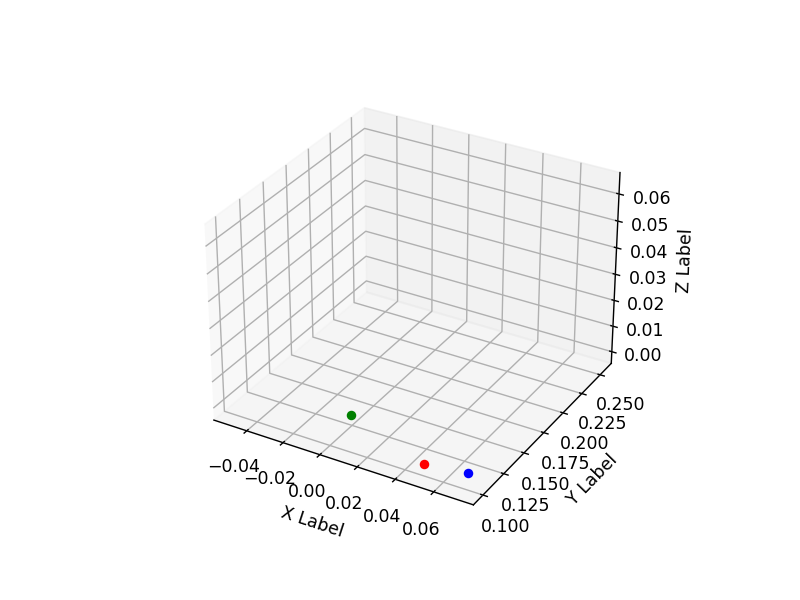

In [62]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = data.pos[data.tetra[:, tetra_idx]]
vertex = p[0].numpy()
lines = combinations(vertex, 2)
for x in lines:
    line=np.transpose(np.array(x))
    ax.plot3D(line[0],line[1],line[2],c='0')
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.scatter(rp[0,0], rp[0,1], rp[0,2], color='red')
ax.scatter(re[0,0], re[0,1], re[0,2], color='blue')
ax.scatter(re[1,0], re[1,1], re[1,2], color='green')